# E2E solution of fraud detection

## Introduction

In this notebook, we'll demonstrate data engineering and data science work flow with an e2e sample. The scenario is to build a model for detecting fraud credit card transactions.


## Step 1: Load the Data

The dataset contains transactions made by credit cards in September 2013 by European cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.

```
==> creditcard.csv <==
"Time","V1","V2","V3","V4","V5","V6","V7","V8","V9","V10","V11","V12","V13","V14","V15","V16","V17","V18","V19","V20","V21","V22","V23","V24","V25","V26","V27","V28","Amount","Class"
0,-1.3598071336738,-0.0727811733098497,2.53634673796914,1.37815522427443,-0.338320769942518,0.462387777762292,0.239598554061257,0.0986979012610507,0.363786969611213,0.0907941719789316,-0.551599533260813,-0.617800855762348,-0.991389847235408,-0.311169353699879,1.46817697209427,-0.470400525259478,0.207971241929242,0.0257905801985591,0.403992960255733,0.251412098239705,-0.018306777944153,0.277837575558899,-0.110473910188767,0.0669280749146731,0.128539358273528,-0.189114843888824,0.133558376740387,-0.0210530534538215,149.62,"0"
0,1.19185711131486,0.26615071205963,0.16648011335321,0.448154078460911,0.0600176492822243,-0.0823608088155687,-0.0788029833323113,0.0851016549148104,-0.255425128109186,-0.166974414004614,1.61272666105479,1.06523531137287,0.48909501589608,-0.143772296441519,0.635558093258208,0.463917041022171,-0.114804663102346,-0.183361270123994,-0.145783041325259,-0.0690831352230203,-0.225775248033138,-0.638671952771851,0.101288021253234,-0.339846475529127,0.167170404418143,0.125894532368176,-0.00898309914322813,0.0147241691924927,2.69,"0"
```

**By defining below parameters, we can apply this notebook on different datasets easily.**

In [14]:
IS_CUSTOM_DATA = False    # if True, dataset has to be uploaded manually

TARGET_COL = 'Class'      # target column name
IS_SAMPLE = False         # if True, use only <SAMPLE_ROWS> rows of data for training, otherwise use all data
SAMPLE_ROWS = 5000        # if IS_SAMPLE is True, use only this number of rows for training

DATA_FOLDER = 'Files/fraud-detection/'  # folder with data files
DATA_FILE = 'creditcard.csv'            # data file name

StatementMeta(, d37e176c-10b0-4252-a240-5a1087ce054f, 16, Finished, Available)

### Download dataset and Upload to lakehouse

In [16]:
if not IS_CUSTOM_DATA:
    # Download demo data files into lakehouse if not exist
    remote_url = 'https://synapseaisolutionsa.blob.core.windows.net/public/Credit_Card_Fraud_Detection'
    file_list = ['creditcard.csv']

    # For this demo, we first check if the dataset files are already prepared in the default lakehouse. If not, we'll download the dataset.
    import os
    import requests

    if not os.path.exists('/lakehouse/default'):
        # ask user to add a lakehouse if no default lakehouse added to the notebook.
        # a new notebook will not link to any lakehouse by default.
        raise FileNotFoundError('Default lakehouse not found, please add a lakehouse for the notebook.')
    else:
        # check if the needed files are already in the lakehouse, try to download if not.
        # raise an error if downloading failed.
        os.makedirs(f'/lakehouse/default/{DATA_FOLDER}/raw/', exist_ok=True)
        for fname in file_list:
            if not os.path.exists(f'/lakehouse/default/{DATA_FOLDER}/raw/{fname}'):
                try:
                    r = requests.get(f'{remote_url}/{fname}', timeout=30)  
                    with open(f'/lakehouse/default/{DATA_FOLDER}/raw/{fname}', 'wb') as f:
                        f.write(r.content)
                    print(f'Downloaded {fname} into {DATA_FOLDER}/raw/.')
                except Exception as e:
                    print(f'Failed on downloading {fname}, error message: {e}')
            else:
                print(f'{fname} already exists in {DATA_FOLDER}/raw/.')

StatementMeta(, d37e176c-10b0-4252-a240-5a1087ce054f, 18, Finished, Available)

In [17]:
# to record the notebook running time
import time

ts = time.time()

StatementMeta(, d37e176c-10b0-4252-a240-5a1087ce054f, 19, Finished, Available)

### Read data from lakehouse

In [18]:
df = spark.read.format("csv") \
               .option("header","true") \
               .option('inferSchema', True) \
               .load(f"{DATA_FOLDER}/raw/{DATA_FILE}")

StatementMeta(, d37e176c-10b0-4252-a240-5a1087ce054f, 20, Finished, Available)

## Step 2. Exploratory Data Analysis

### Display Raw Data

We can explore the raw data with `display`, do some basic statistcs or even show chart views.

In [19]:
display(df)

StatementMeta(, d37e176c-10b0-4252-a240-5a1087ce054f, 21, Finished, Available)

SynapseWidget(Synapse.DataFrame, 00a7df22-4a3f-450c-8382-03b6c782587d)

In [20]:
# print dataset basic info
print("records read: " + str(df.count()))
print("Schema: ")
df.printSchema()

StatementMeta(, d37e176c-10b0-4252-a240-5a1087ce054f, 22, Finished, Available)

records read: 284807
Schema: 
root
 |-- Time: double (nullable = true)
 |-- V1: double (nullable = true)
 |-- V2: double (nullable = true)
 |-- V3: double (nullable = true)
 |-- V4: double (nullable = true)
 |-- V5: double (nullable = true)
 |-- V6: double (nullable = true)
 |-- V7: double (nullable = true)
 |-- V8: double (nullable = true)
 |-- V9: double (nullable = true)
 |-- V10: double (nullable = true)
 |-- V11: double (nullable = true)
 |-- V12: double (nullable = true)
 |-- V13: double (nullable = true)
 |-- V14: double (nullable = true)
 |-- V15: double (nullable = true)
 |-- V16: double (nullable = true)
 |-- V17: double (nullable = true)
 |-- V18: double (nullable = true)
 |-- V19: double (nullable = true)
 |-- V20: double (nullable = true)
 |-- V21: double (nullable = true)
 |-- V22: double (nullable = true)
 |-- V23: double (nullable = true)
 |-- V24: double (nullable = true)
 |-- V25: double (nullable = true)
 |-- V26: double (nullable = true)
 |-- V27: double (nullable =

### Cast columns into the correct types

In [21]:
import pyspark.sql.functions as F
from pyspark.sql.functions import col
from pyspark.sql.types import IntegerType

df_columns = df.columns
df_columns.remove(TARGET_COL)
df = df.select(df_columns + [TARGET_COL])  # to make sure the TARGET_COL is the last column
df = df.withColumn(TARGET_COL, col(TARGET_COL).cast(IntegerType()))

if IS_SAMPLE:
    df = df.limit(SAMPLE_ROWS)

StatementMeta(, d37e176c-10b0-4252-a240-5a1087ce054f, 23, Finished, Available)

## Step 3. Model development and deploy
We have explored the dataset, got some insights from the exploratory data analysis.

Next, we'll develop a lightgbm model to classify fraud transactions.

### Prepare training and testing data

In [22]:
# Split the dataset into train and test
train, test = df.randomSplit([0.85, 0.15], seed=42)

StatementMeta(, d37e176c-10b0-4252-a240-5a1087ce054f, 24, Finished, Available)

In [23]:
# Merge Columns
from pyspark.ml.feature import VectorAssembler
feature_cols = df.columns[:-1]
featurizer = VectorAssembler(
    inputCols=feature_cols,
    outputCol='features'
)
train_data = featurizer.transform(train)[TARGET_COL, 'features']
test_data = featurizer.transform(test)[TARGET_COL, 'features']

StatementMeta(, d37e176c-10b0-4252-a240-5a1087ce054f, 25, Finished, Available)

### Check data volumn and imbalance

In [24]:
display(train_data.groupBy(TARGET_COL).count())

StatementMeta(, d37e176c-10b0-4252-a240-5a1087ce054f, 26, Finished, Available)

SynapseWidget(Synapse.DataFrame, 129c9eef-23f3-4319-9a11-053a2d9e3c05)

### Handle imbalance data
We'll apply [SMOTE](https://arxiv.org/abs/1106.1813) (Synthetic Minority Over-sampling Technique) to automatically handle imbalance data. A dataset is imbalanced if the classification categories are not approximately equally represented. Often real-world data sets are predominately composed of "normal" examples with only a small percentage of "abnormal" or "interesting" examples. It is also the case that the cost of misclassifying an abnormal (interesting) example as a normal example is often much higher than the cost of the reverse error. Under-sampling of the majority (normal) class has been proposed as a good means of increasing the sensitivity of a classifier to the minority class. This paper shows that a combination of our method of over-sampling the minority (abnormal) class and under-sampling the majority (normal) class can achieve better classifier performance (in ROC space) than only under-sampling the majority class. 

In [25]:
# install imblearn for SMOTE
!pip install imblearn

StatementMeta(, d37e176c-10b0-4252-a240-5a1087ce054f, 27, Finished, Available)

#### Apply SMOTE for new train_data 
imblearn only works for pandas dataframe, not pyspark dataframe.

In [26]:
from pyspark.ml.functions import vector_to_array, array_to_vector
import numpy as np
from collections import Counter
from imblearn.over_sampling import SMOTE 

train_data_array = train_data.withColumn('features', vector_to_array('features'))

train_data_pd = train_data_array.toPandas()

X = train_data_pd['features'].to_numpy()
y = train_data_pd[TARGET_COL].to_numpy()
print('Original dataset shape %s' % Counter(y))

X = np.array([np.array(x) for x in X])

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)
print('Resampled dataset shape %s' % Counter(y_res))

new_train_data = tuple(zip(X_res.tolist(), y_res.tolist()))
dataColumns = ["features",TARGET_COL]
new_train_data = spark.createDataFrame(data=new_train_data, schema = dataColumns)
new_train_data = new_train_data.withColumn('features', array_to_vector('features'))

StatementMeta(, d37e176c-10b0-4252-a240-5a1087ce054f, 28, Finished, Available)

Original dataset shape Counter({0: 242064, 1: 406})
Resampled dataset shape Counter({0: 242064, 1: 242064})


### Define the Model

With our data in place, we can now define the model. We'll apply lightgbm model in this notebook. 

We'll leverage SynapseML to implement the model within a few lines of code.

In [27]:
from mmlspark.lightgbm import LightGBMClassifier
model = LightGBMClassifier(objective="binary", featuresCol="features", labelCol=TARGET_COL, isUnbalance=True)
smote_model = LightGBMClassifier(objective="binary", featuresCol="features", labelCol=TARGET_COL, isUnbalance=False)

StatementMeta(, d37e176c-10b0-4252-a240-5a1087ce054f, 29, Finished, Available)

/home/trusted-service-user/cluster-env/env/lib/python3.8/site-packages/mmlspark/__init__.py:4: UserWarning: The mmlspark namespace has been deprecated. Please change import statements to import from synapse.ml
  warnings.warn(


### Model training

In [28]:
model = model.fit(train_data)
smote_model = smote_model.fit(new_train_data)

StatementMeta(, d37e176c-10b0-4252-a240-5a1087ce054f, 30, Finished, Available)

### Model Explanation
Here we can show the importance of each column.

StatementMeta(, d37e176c-10b0-4252-a240-5a1087ce054f, 31, Finished, Available)

f_index: Index(['V13', 'V5', 'V24', 'V18', 'V26', 'Time', 'V6', 'V16', 'V25', 'V21',
       'V1', 'V27', 'V3', 'V9', 'V22', 'V17', 'V2', 'V28', 'V19', 'V15', 'V11',
       'V23', 'V8', 'V12', 'V10', 'V4', 'V7', 'Amount', 'V20', 'V14'],
      dtype='object')
f_values: [ 48.  52.  53.  53.  53.  58.  66.  68.  70.  73.  75.  77.  77.  78.
  81.  87.  87.  88.  91.  92.  93. 106. 117. 117. 137. 142. 192. 202.
 224. 243.]


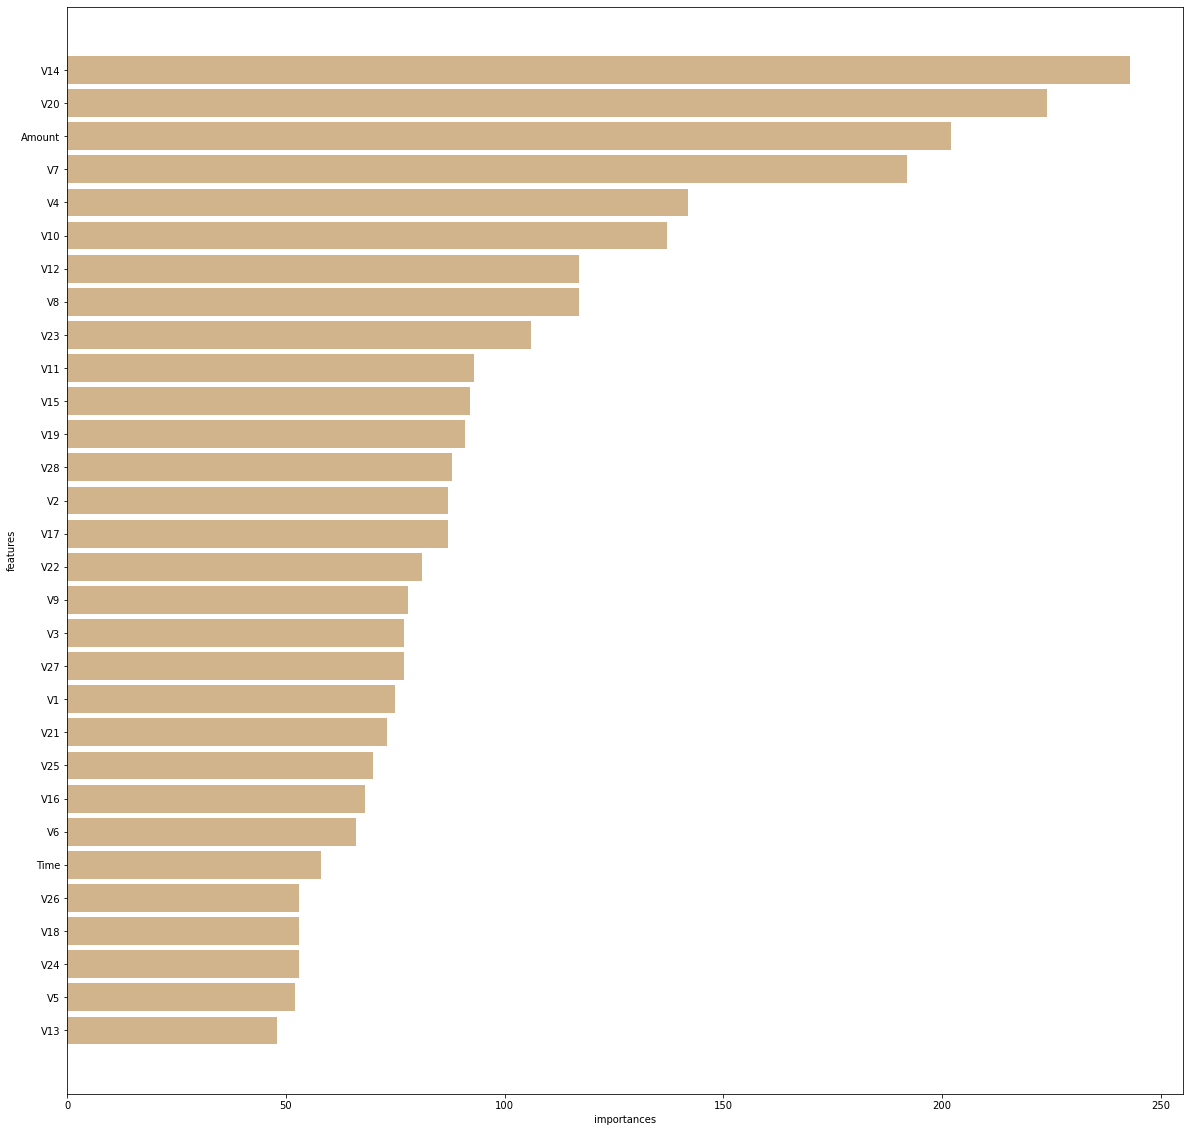

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

feature_importances = model.getFeatureImportances()
fi = pd.Series(feature_importances,index = feature_cols)
fi = fi.sort_values(ascending = True)
f_index = fi.index
f_values = fi.values

# print feature importances
print ('f_index:',f_index)
print ('f_values:',f_values)

# plot
x_index = list(range(len(fi)))
x_index = [x/len(fi) for x in x_index]
plt.rcParams['figure.figsize'] = (20,20)
plt.barh(x_index,f_values,height = 0.028 ,align="center",color = 'tan',tick_label=f_index)
plt.xlabel('importances')
plt.ylabel('features')
plt.show()

### Model Evaluation

In [30]:
predictions = model.transform(test_data)
predictions.limit(10).toPandas()

StatementMeta(, d37e176c-10b0-4252-a240-5a1087ce054f, 32, Finished, Available)

/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:87: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unsupported type in conversion to Arrow: VectorUDT
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warnings.warn(msg)


,Class,features,rawPrediction,probability,prediction
0,0,"[4.0, 1.22965763450793, 0.141003507049326, 0.0...","[-3150.268915835998, 3150.268915835998]","[0.0, 1.0]",1.0
1,0,"[7.0, -0.644269442348146, 1.41796354547385, 1....","[169034.33780864603, -169034.33780864603]","[1.0, 0.0]",0.0
2,0,"[18.0, 1.16661638244228, 0.502120087854101, -0...","[34347.286518619054, -34347.286518619054]","[1.0, 0.0]",0.0
3,0,"[26.0, -0.529912284186556, 0.873891581460326, ...","[40309.54741837494, -40309.54741837494]","[1.0, 0.0]",0.0
4,0,"[34.0, 0.201685891430752, 0.497483215432781, 1...","[59359.239796146925, -59359.239796146925]","[1.0, 0.0]",0.0
5,0,"[34.0, 1.13831556625444, 0.0569559699973862, 0...","[6641.496620362767, -6641.496620362767]","[1.0, 0.0]",0.0
6,0,"[35.0, 1.19935593362078, 0.129953154513887, 0....","[-13521.33560431497, 13521.33560431497]","[0.0, 1.0]",1.0
7,0,"[36.0, -1.16942245796433, 1.15831387032695, 1....","[119665.99243411428, -119665.99243411428]","[1.0, 0.0]",0.0
8,0,"[38.0, 0.158331782301759, 0.872687435246972, 0...","[245883.22811995086, -245883.22811995086]","[1.0, 0.0]",0.0
9,0,"[41.0, 1.15431211678574, 0.265462317325236, 0....","[93869.59708456328, -93869.59708456328]","[1.0, 0.0]",0.0


In [31]:
from mmlspark.train import ComputeModelStatistics
metrics = ComputeModelStatistics(evaluationMetric="classification", labelCol=TARGET_COL, scoredLabelsCol='prediction').transform(predictions)
display(metrics)

StatementMeta(, d37e176c-10b0-4252-a240-5a1087ce054f, 33, Finished, Available)

SynapseWidget(Synapse.DataFrame, 321bcb75-ff5c-46b9-be16-a19d1fe0680e)

In [32]:
# collect confusion matrix value
cm = metrics.select('confusion_matrix').collect()[0][0].toArray()
print(cm)

StatementMeta(, d37e176c-10b0-4252-a240-5a1087ce054f, 34, Finished, Available)

[[3.8378e+04 3.8730e+03]
 [1.2000e+01 7.4000e+01]]


StatementMeta(, d37e176c-10b0-4252-a240-5a1087ce054f, 35, Finished, Available)

Text(30.5, 0.5, 'True label')

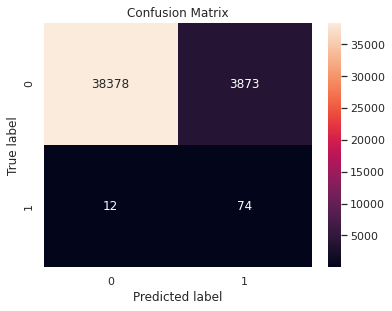

In [33]:
# plot confusion matrix
import seaborn as sns

sns.set(rc = {'figure.figsize':(6, 4.5)})
ax = sns.heatmap(cm, annot=True, fmt='.20g')
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')

In [34]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# initialize the binary evaluator
evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction", labelCol=TARGET_COL)

# calculate AUROC 
auroc = evaluator.evaluate(predictions, {evaluator.metricName: 'areaUnderROC'})  # baseline 0.5
print(f'AUROC: {auroc:.4f}')

# calculate AUPRC
auprc = evaluator.evaluate(predictions, {evaluator.metricName: 'areaUnderPR'})  # baseline 0.172%
print(f'AUPRC: {auprc:.4f}')

StatementMeta(, d37e176c-10b0-4252-a240-5a1087ce054f, 36, Finished, Available)

AUROC: 0.8844
AUPRC: 0.0176


In [35]:
new_predictions = smote_model.transform(test_data)

# calculate AUROC 
new_auroc = evaluator.evaluate(new_predictions, {evaluator.metricName: 'areaUnderROC'})  # baseline 0.5
print(f'SMOTE AUROC: {new_auroc:.4f}')

# calculate AUPRC
new_auprc = evaluator.evaluate(new_predictions, {evaluator.metricName: 'areaUnderPR'})  # baseline 0.172%
print(f'SMOTE AUPRC: {new_auprc:.4f}')

StatementMeta(, d37e176c-10b0-4252-a240-5a1087ce054f, 37, Finished, Available)

SMOTE AUROC: 0.9126
SMOTE AUPRC: 0.7203


In [36]:
if new_auprc > auprc:
    # Using model trained on SMOTE data if it has higher AUPRC
    model = smote_model

StatementMeta(, d37e176c-10b0-4252-a240-5a1087ce054f, 38, Finished, Available)

### Save Model
Now we get a pretty good model, we can save it for later use.

In [37]:
from mmlspark.lightgbm import LightGBMClassificationModel
import time

saved_model_path = f'{DATA_FOLDER}/lightgbm_model/{int(time.time())}'
model.saveNativeModel(saved_model_path)
print(f'model is saved in: {saved_model_path}')

StatementMeta(, d37e176c-10b0-4252-a240-5a1087ce054f, 39, Finished, Available)

model is saved in: Files/fraud-detection//lightgbm_model/1660023627


## Step 4. Save Prediction Results

### Model Deploy and Prediction

Load Model back

In [38]:
# # Load Model

# from mmlspark.lightgbm import LightGBMClassificationModel

# saved_model_path = f'{DATA_FOLDER}/lightgbm_model/1657028446'
# model1 = LightGBMClassificationModel.loadNativeModelFromFile(saved_model_path)

StatementMeta(, d37e176c-10b0-4252-a240-5a1087ce054f, 40, Finished, Available)

In [39]:
batch_predictions = model.transform(test_data)

StatementMeta(, d37e176c-10b0-4252-a240-5a1087ce054f, 41, Finished, Available)

In [40]:
# code for saving predictions into lakehouse
batch_predictions.write.mode('overwrite').parquet(f"{DATA_FOLDER}/predictions/batch_predictions")

StatementMeta(, d37e176c-10b0-4252-a240-5a1087ce054f, 42, Finished, Available)

In [41]:
print(f'Full run cost {int(time.time() - ts)} seconds.')

StatementMeta(, d37e176c-10b0-4252-a240-5a1087ce054f, 43, Finished, Available)

Full run cost 86 seconds.
